### 1. Preprocess and split all books into segments

In [ ]:
%load_ext autoreload
%autoreload 2
import json
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from book_segmenting import TextSegmenter
from book_preprocessing import TxtBookPreprocessor
from utils import SEGMENT_DIR, BOOK_DIR

SEGMENT_CHARS_MIN = 150
SEGMENT_CHARS_MAX = 500

preprocessor = TxtBookPreprocessor()
segmenter = TextSegmenter(chunk_size=(SEGMENT_CHARS_MIN, SEGMENT_CHARS_MAX))

for f in SEGMENT_DIR.glob("*.json"):
    f.unlink()
for book in BOOK_DIR.glob("*.txt"):
    with open(book, "r", encoding="utf-8-sig") as f:
        book_content = f.read()
    book_slug = book.stem
    chunks = segmenter.segment_text(preprocessor.clean_text(book_content))
    with open(SEGMENT_DIR / f"{book_slug}.json", "w", encoding="utf-8") as f:
        json.dump(chunks, f, indent=2)

### 2. Sample N segments from all unused yet

In [4]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from utils import SEGMENT_DIR, TO_ANNOTATE_DIR, BOOK_META_DIR
from dataset_small.segment_sampling import SegmentSampler

N = 500
BATCH_NAME = "batch_001"
MAX_PER_BOOK = 3
SEED = 42

sampler = SegmentSampler(SEGMENT_DIR, BOOK_META_DIR, TO_ANNOTATE_DIR, SEED)
# sample = sampler.sample_balanced(N, BATCH_NAME, max_per_book=MAX_PER_BOOK)
sampler.print_status()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Available: 426673 segments
  Western: only 51 available (wanted 71)
  History: only 3 available (wanted 71)
  Travel: only 3 available (wanted 71)

Saved 500 segments to /home/terra/Projects/vis-desc/modules/lab/data/to-annotate/batch_001.json
=== CORPUS STATUS ===
Books: 290
Total segments: 426673
Used segments: 500
Available: 426173

By genre:
  Fiction: 208421 (137 books)
  Mystery: 88117 (62 books)
  Fantasy: 51919 (42 books)
  Science Fiction: 40740 (30 books)
  Western: 35619 (17 books)
  History: 929 (1 books)
  Travel: 928 (1 books)


Saved pie to /home/terra/Projects/vis-desc/modules/lab/data/genre_distribution.png


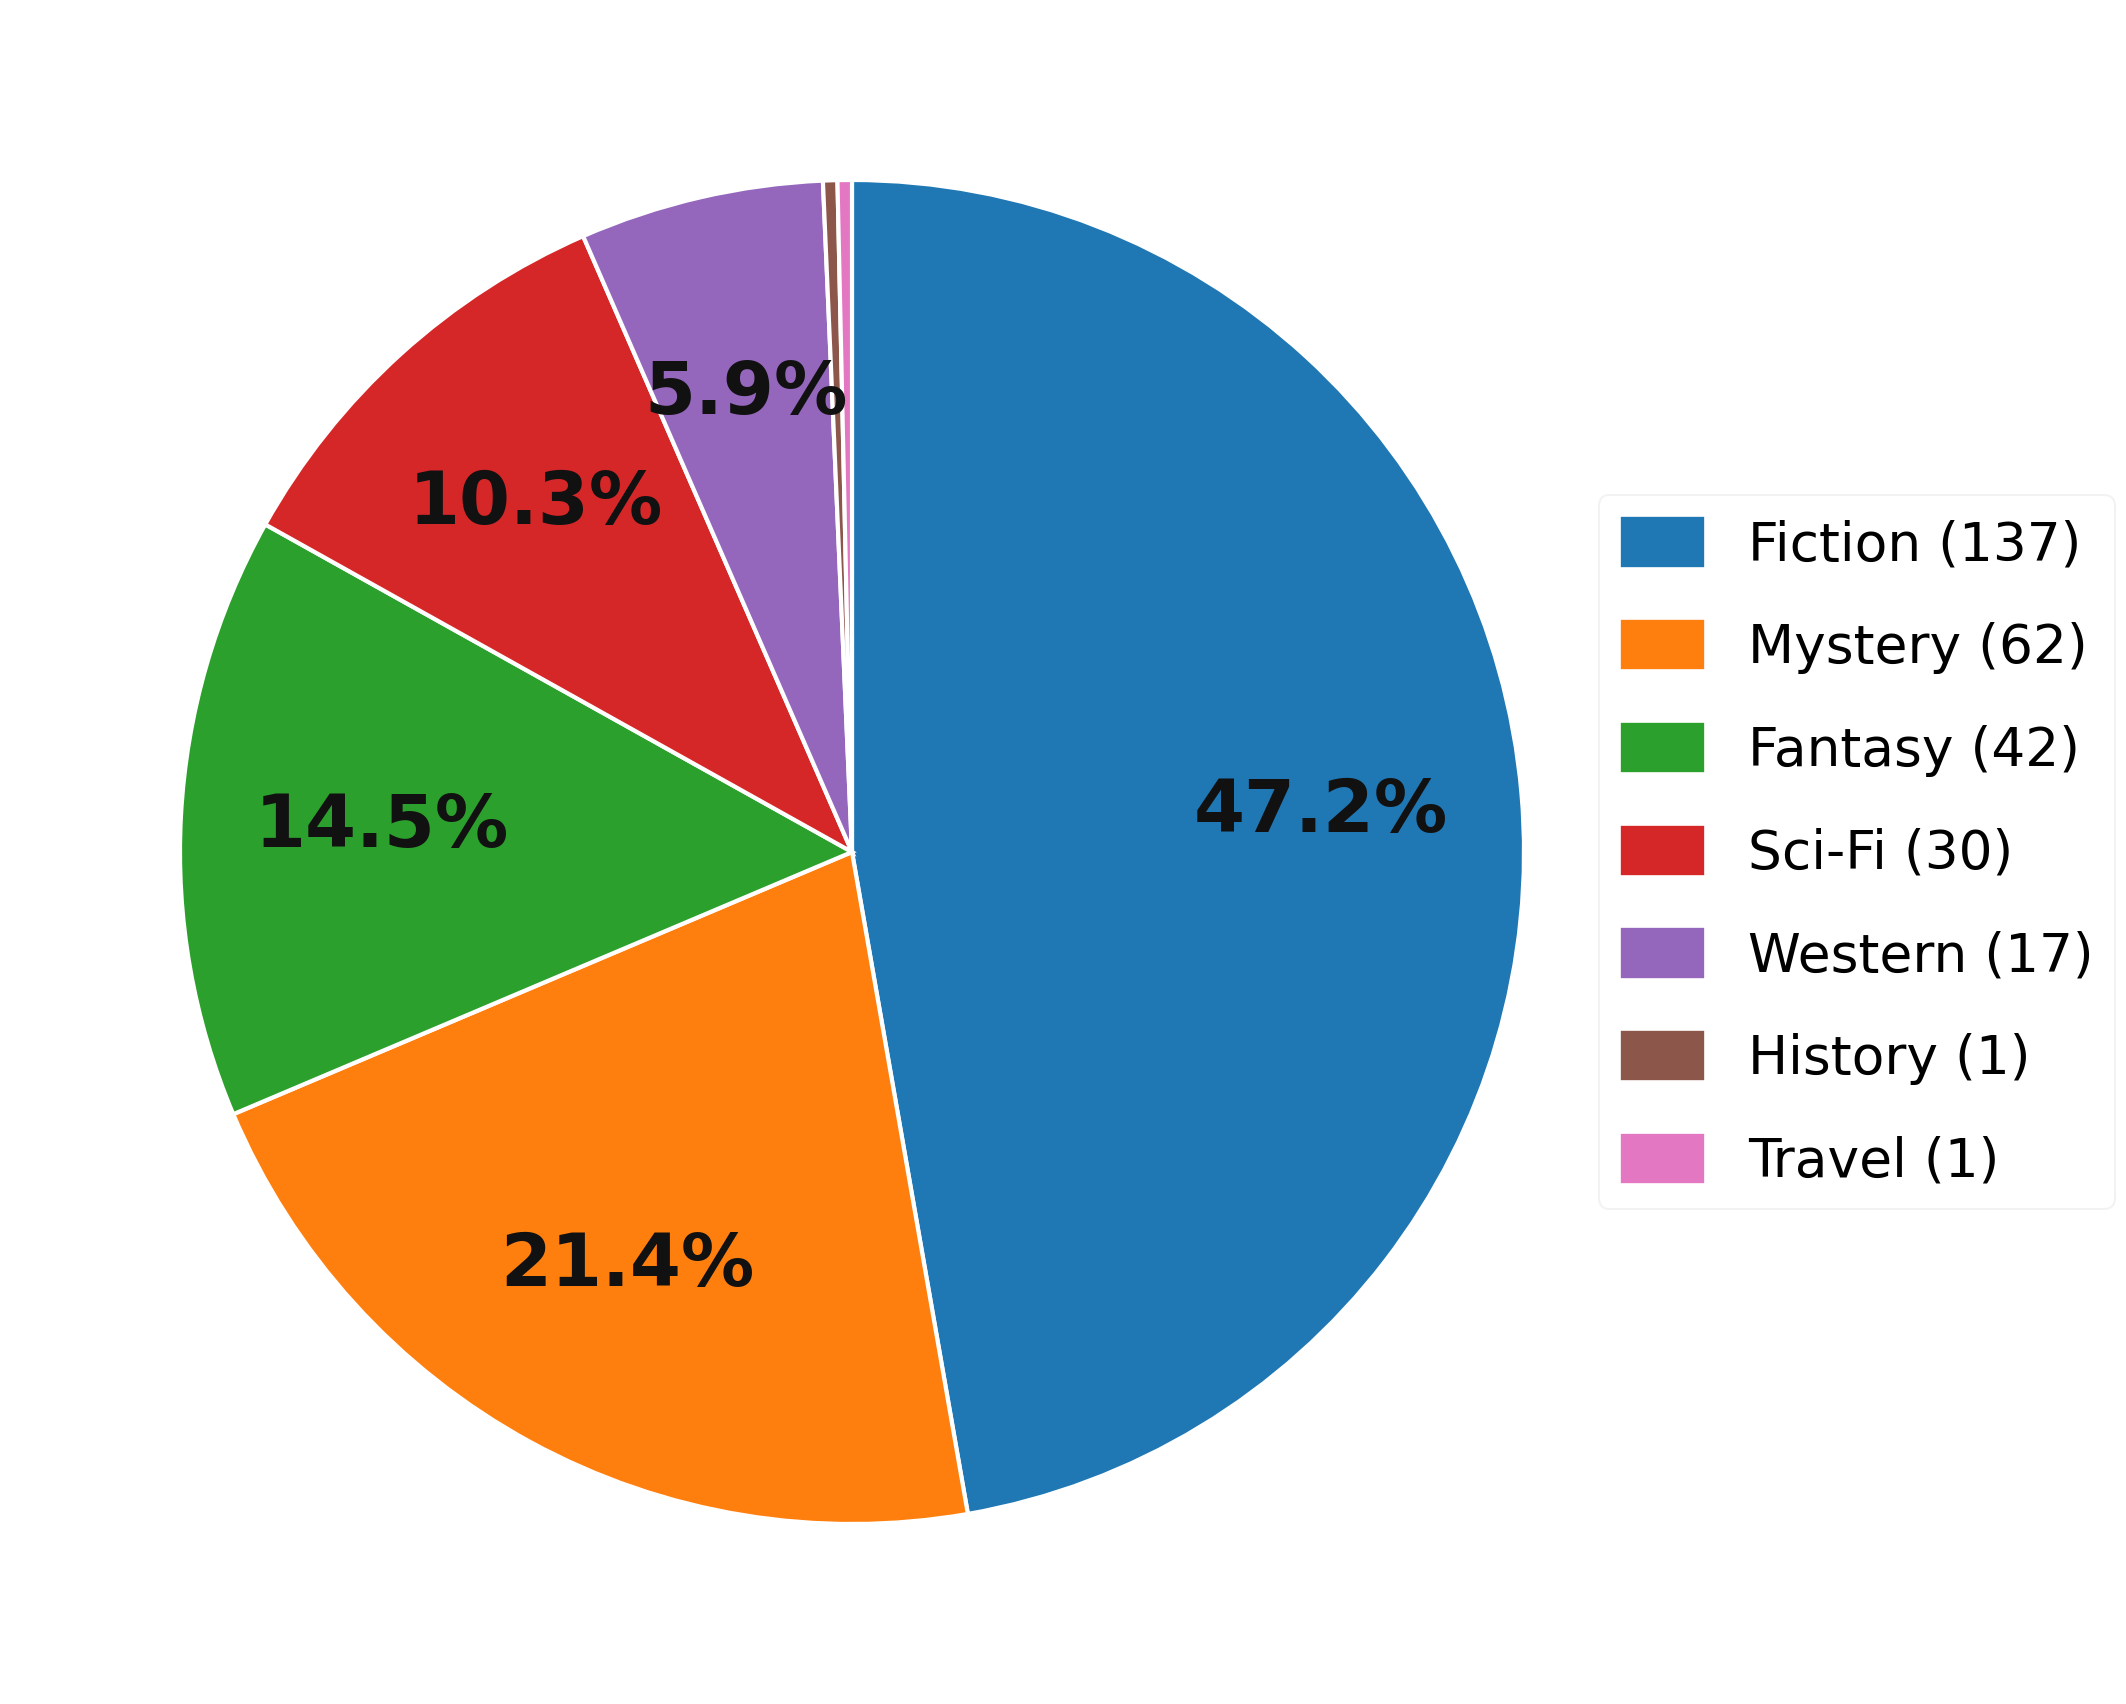

Total books counted: 290
Done.


In [36]:
import json
import collections
from pathlib import Path
import matplotlib.pyplot as plt
from utils import BOOK_META_DIR, DATA_DIR

genre_counts = collections.Counter()
for meta_file in BOOK_META_DIR.glob("*.json"):
    try:
        with open(meta_file, "r", encoding="utf-8") as f:
            data = json.load(f)
        g = data.get("genre") or "Unknown"
        if isinstance(g, str):
            g = g.strip() or "Unknown"
        else:
            g = "Unknown"
        if g.lower() == "science fiction":
            g = "Sci-Fi"
        genre_counts[g] += 1
    except Exception:
        pass

if not genre_counts:
    print("No genre data found for Matplotlib chart.")
else:
    genres, counts = zip(*genre_counts.most_common())
    total = sum(counts)
    plt.rcParams.update({"font.size": 42, "axes.titlesize": 48, "legend.fontsize": 32})

    fig, ax = plt.subplots(figsize=(20, 14), dpi=120)

    def autopct_fmt(pct):
        return ("%0.1f%%" % pct) if pct >= 1 else ""

    wedges, texts, autotexts = ax.pie(
        counts,
        labels=None,  # legend instead of slice text
        autopct=autopct_fmt,
        startangle=90,
        counterclock=False,
        pctdistance=0.70,
        textprops={"color": "#111", "fontsize": 44},
        wedgeprops={"linewidth": 2.5, "edgecolor": "white"},
    )

    for t in autotexts:
        t.set_fontsize(44)
        t.set_fontweight("bold")

    from matplotlib.patches import Patch

    legend_patches = [
        Patch(facecolor=w.get_facecolor(), edgecolor="white", label=f"{g} ({c})")
        for w, g, c in zip(wedges, genres, counts)
    ]

    fig.subplots_adjust(left=0, right=0.80, top=1, bottom=0)

    leg = fig.legend(
        handles=legend_patches,
        loc="center left",
        bbox_to_anchor=(0.7, 0.5),
        frameon=True,
        title_fontsize=36,
        borderpad=0.4,
        labelspacing=0.9,
        handlelength=1.6,
        handleheight=1.1,
    )
    frame = leg.get_frame()
    frame.set_alpha(0.18)
    frame.set_edgecolor("#bcbcbc")
    frame.set_linewidth(1.2)
    frame.set_facecolor("#ffffff")

    ax.set_aspect("equal")

    pie_path = DATA_DIR / "genre_distribution.png"
    fig.savefig(pie_path, bbox_inches="tight", pad_inches=0, transparent=True)
    print("Saved pie to", pie_path)
    plt.show()
    print("Total books counted:", total)

print("Done.")